In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

In [39]:
data_dir = '/home/david/spiced_projects/final_project/data/recs'
input_samplerate = 22050
plt.style.use('seaborn-v0_8-darkgrid')
spec_cmap = 'gist_ncar'
bsize = 20
last_layer_activation = None
logits = not bool(last_layer_activation)

In [40]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=bsize,
    validation_split=0.2,
    seed=123,
    output_sequence_length=input_samplerate,
    subset='both')

Found 300 files belonging to 3 classes.
Using 240 files for training.
Using 60 files for validation.


In [41]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

def get_spectrogram(wave):
    spec = tf.signal.stft(wave, frame_length=300, frame_step=85)
    spec = tf.abs(spec)
    return spec

def plot_spectrogram(spectrogram, ax):
    ''' Convert the frequencies to log scale and transpose,
        now time is represented on the x-axis (columns).
        Add epsilon to avoid taking a log of zero.
    '''
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, input_samplerate, num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, cmap=spec_cmap)

def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [42]:
label_names = train_ds.class_names

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

for example_audio, example_labels in train_ds.take(1):  
    break

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

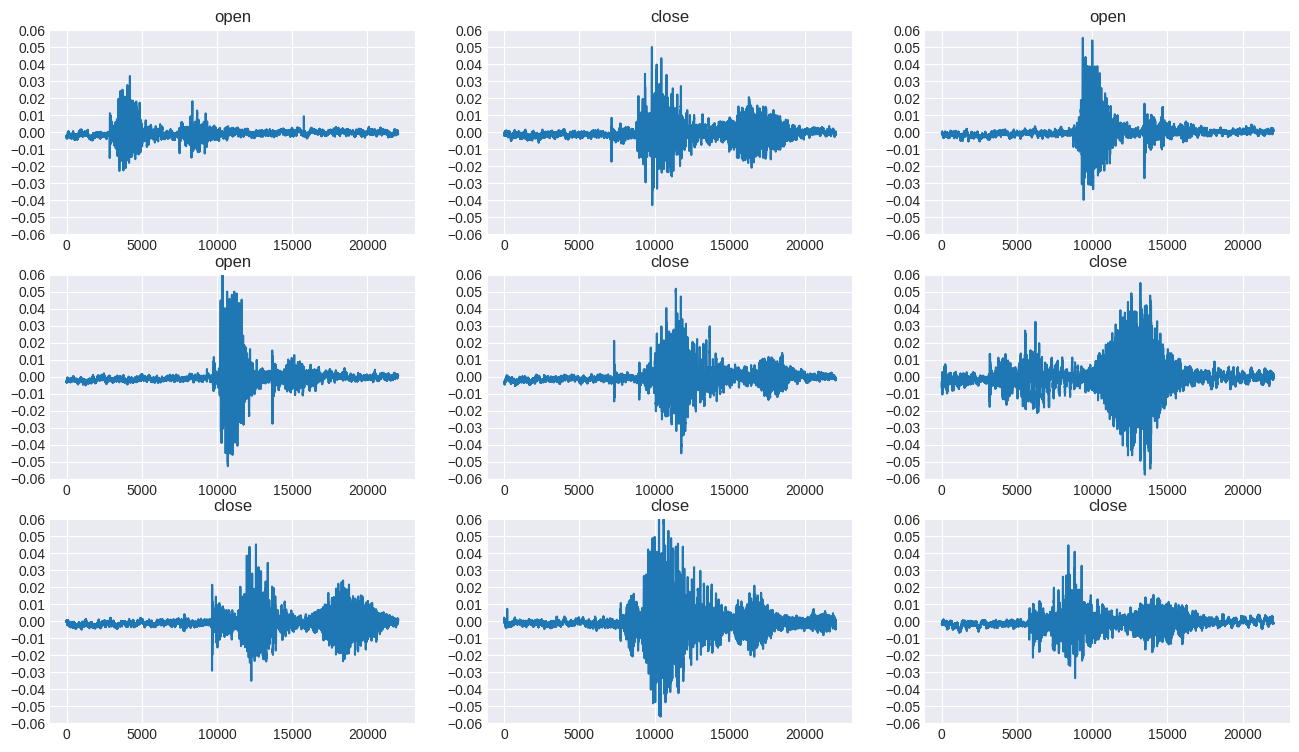

In [43]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-0.1, 0.1, 0.01))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-0.06,0.06])

plt.show()


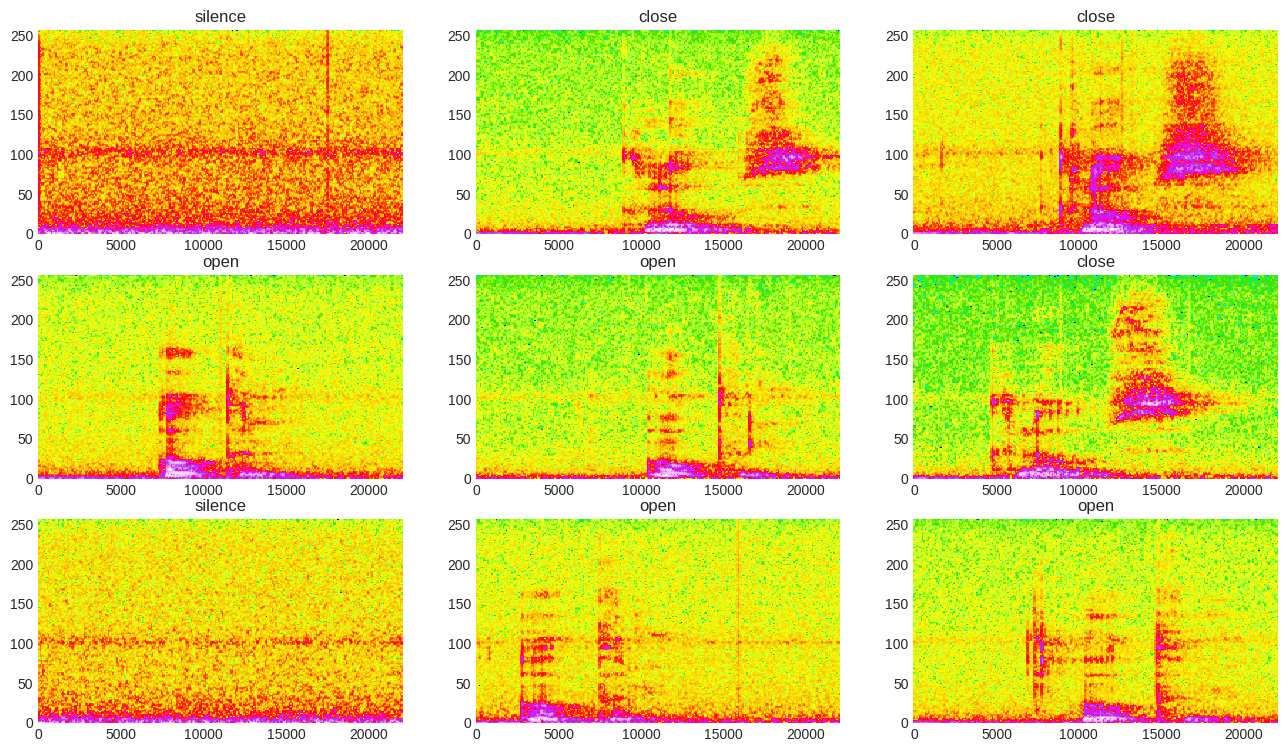

In [44]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [45]:
i = random.randint(0,bsize-1)

label = label_names[example_labels[i]]
waveform = example_audio[i]
spectrogram = get_spectrogram(waveform)
print(spectrogram.shape)

print('Label:', label)

(256, 257)
Label: close


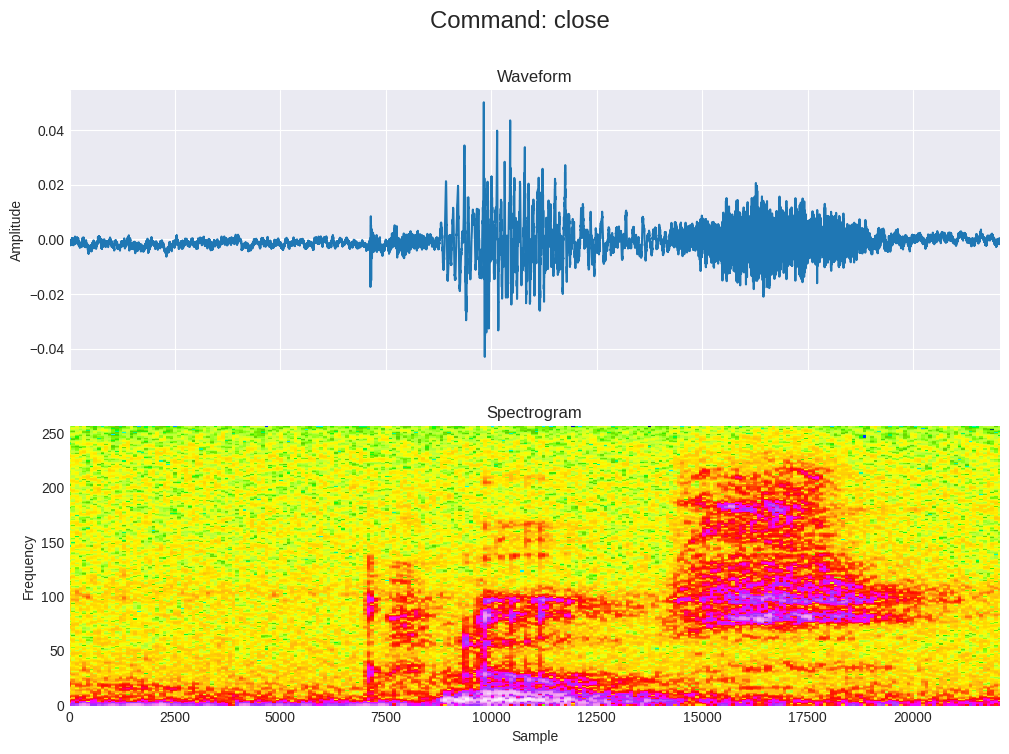

In [47]:
fig, axes = plt.subplots(2, figsize=(12, 8), sharex=True)
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_ylabel("Amplitude")
axes[0].set_xlim([0, input_samplerate])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
axes[1].set_xlabel("Sample")
axes[1].set_ylabel("Frequency")
plt.suptitle(f'Command: {label}').set_fontsize('xx-large')
plt.show()